In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
import json

from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split

# import altair as alt
import mlflow

from sklearn.metrics import  make_scorer
from lightgbm import LGBMRanker, LGBMClassifier #, __version__
from lightgbm import plot_importance
from mlflow.models import infer_signature


from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score
average_precision_scorer = make_scorer(average_precision_score, average='macro')  #, average = 'weighted')
roc_auc_scorer = make_scorer(roc_auc_score, average='macro') #average = 'weighted')

import seaborn as sns
# from mlflow_utils import train_log_model

idx = pd.IndexSlice
import pylab as plt

In [3]:
from model import get_model
from metrics import (
    precision_at_f, precision_at_85,
    recall_at_85, recall_at_f
)

In [4]:
from mlflow_utils import mlflow_log_model

In [5]:
import boto3

boto3.session.Session().available_profiles

['se-stage',
 'se-prod',
 'zgdatalake',
 'zgdatalake-staging',
 'sedatalakeprodreadonly',
 'sedatalakeprodreadwrite',
 'sedatalakeadmin',
 'sedatalakestagingreadonly',
 'sedatalakestagingreadwrite',
 'sedatalakeadmin-stage',
 'default']

In [6]:
# boto3.setup_default_session(profile_name='sedatalakestagingreadwrite')
boto3.setup_default_session(profile_name='sedatalakeprodreadwrite')

In [7]:
METRICS = [
    make_scorer(average_precision_score, average='macro'),  #, average = 'weighted')
    make_scorer(roc_auc_score, average='macro'),
    make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_f, needs_proba=True, greater_is_better=True)
]


/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## Load Data

In [8]:
X_train = pd.read_parquet('./data/train/X_query_train.parquet')
y_train = pd.read_parquet('./data/train/y_query_train.parquet').iloc[:, 0]

In [9]:
X_val = pd.read_parquet('./data/train/X_query_val.parquet')
y_val = pd.read_parquet('./data/train/y_query_val.parquet').iloc[:, 0]

In [10]:
X_old_val = pd.read_parquet('./data/train/Xval.parquet')
y_old_val = pd.read_parquet('./data/train/yval.parquet').iloc[:, 0]

In [11]:
with open('./data/train/groups.json', 'r') as f:
    groups = json.load(f)

## Model

In [12]:
import lightgbm as lgb

model = lgb.LGBMRanker()

In [13]:
metaflow_config = dict(
    tracking_uri='https://mlflow.production.streeteasy.cloud',
    experiment_name='expert_transaction_matching',
    model_name='expert_transaction_matching'
)

In [14]:
sum(groups['val'])

102697

In [15]:
len(y_val)

102697

In [16]:
w_train = np.where(y_train, 50, 1)

In [17]:
w_train

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
model.fit(X_train, y_train, sample_weight=w_train, group=groups['train'],
        eval_set=[(X_val, y_val)], eval_group=[groups['val']],
        eval_at=[5, 10, 20])

[LightGBM] [Info] Calculating query weights...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 972614, number of used features: 17


LGBMRanker()

In [19]:
def map_to_proba(val):
    return (val - val.min()) / (val.max() - val.min())

In [20]:
y_proba = map_to_proba(model.predict(X_val))

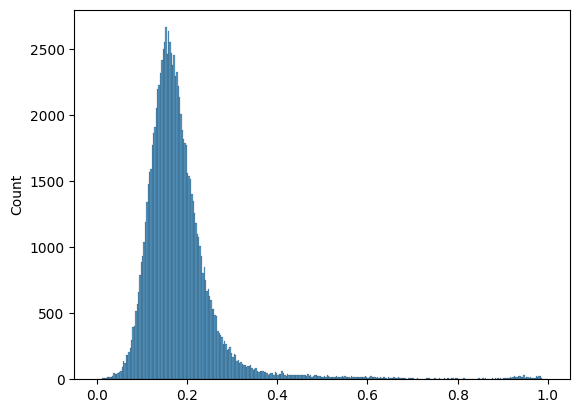

In [21]:
sns.histplot(y_proba);

In [22]:
fpr, tpr, _ = roc_curve(y_val, y_proba, pos_label=1)
prec, recall, _ = precision_recall_curve(yval, y_proba, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

NameError: name 'yval' is not defined

In [ ]:
prec, recall, step = precision_recall_curve(yval, y_proba, pos_label=1)

In [ ]:
pd.DataFrame({'precisson':prec[:-1], 'recall':recall[:-1]}, index=step).plot();
plt.show()

### Initial Validation Set

In [ ]:
y_proba2 = map_to_proba(model.predict(X_old_val))

In [ ]:
sns.histplot(y_proba2);

In [ ]:
fpr, tpr, _ = roc_curve(y_old_val, y_proba2, pos_label=1)
prec, recall, _ = precision_recall_curve(y_old_val, y_proba2, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [ ]:
prec, recall, step = precision_recall_curve(y_old_val, y_proba2, pos_label=1)

In [ ]:
pd.DataFrame({'precisson':prec[:-1], 'recall':recall[:-1]}, index=step).plot();
plt.show()

In [23]:
mlflow.set_tracking_uri(metaflow_config["tracking_uri"])  # type: ignore
mlflow.set_experiment(metaflow_config["experiment_name"])

<Experiment: artifact_location='s3://streeteasy-datalake/research/mlflow/793', creation_time=1711393472926, experiment_id='793', last_update_time=1711393472926, lifecycle_stage='active', name='expert_transaction_matching', tags={}>

In [24]:
mlflow.autolog()

2024/03/28 12:45:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/28 12:45:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/28 12:45:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [25]:
params = {'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [26]:
model.set_params(**{k[len('model__'):]:v for k, v in params.items()})
# model.steps = model.steps[1:]
# model.steps[0][1].transformers[0][1].sparse_output = False

LGBMRanker(colsample_bytree=0.5013544317317782, min_child_samples=51,
           min_child_weight=1e-05, num_leaves=21, reg_alpha=0.1, reg_lambda=5,
           subsample=0.4301443471481221)

In [27]:
METRICS = [
    make_scorer(average_precision_score, average='macro'),  #, average = 'weighted')
    make_scorer(roc_auc_score, average='macro'),
    make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_85, needs_proba=True, greater_is_better=True),
    make_scorer(precision_at_85, needs_proba=True, greater_is_better=True),
]

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [96]:
# from sklearn.dummy import DummyClassifier
from sklearn.base import ClassifierMixin


class LGBMRankerBinaryClassifier(ClassifierMixin, lgb.LGBMRanker):
    classes_ = np.array([0, 1])
    

    @staticmethod
    def map_to_01(val):
        return (val - val.min()) / (val.max() - val.min())
    
    def predict_proba(self, X, *args, **kwargs):
        val = self.predict(X, *args, **kwargs)
        scaled = self.map_to_01(val).reshape(-1, 1)
        bidir = np.hstack((scaled, 1-scaled))
        return bidir
    
   

In [98]:
M = LGBMRankerBinaryClassifier()

In [102]:
M.fit(X_train, y_train,  sample_weight=w_train, group=groups['train'])

2024/03/28 13:40:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f49c460c23b843cd88fb074b6d9c19ba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2024/03/28 13:40:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these colum

[LightGBM] [Info] Calculating query weights...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 972614, number of used features: 17


2024/03/28 13:41:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 13:42:07 WARNING mlflow.models.model: Logging model metadata to the trac

LGBMRankerBinaryClassifier()

In [103]:
M.predict_proba(X_val).shape

2024/03/28 13:42:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 13:42:09 WARNING mlflow.sklearn: Failed to log evaluation dataset inform

(102697, 2)

In [104]:
M.set_params(**{k[len('model__'):]:v for k, v in params.items()})

LGBMRankerBinaryClassifier(colsample_bytree=0.5013544317317782,
                           min_child_samples=51, min_child_weight=1e-05,
                           num_leaves=21, reg_alpha=0.1, reg_lambda=5,
                           subsample=0.4301443471481221)

In [105]:
mlflow.set_tracking_uri(metaflow_config["tracking_uri"])  # type: ignore
mlflow.set_experiment(metaflow_config["experiment_name"])

    
with mlflow.start_run(run_name=metaflow_config.get("run_name")):
    M.fit(X_train, y_train, 
              sample_weight=w_train,
              group=groups['train'])

    mlflow.set_tags({'model':'lgbm_ranking'})
#     mlflow.log_params(model.get_params())

    signature = infer_signature(X_train, y_train)
    
    mlflow.sklearn.log_model(
        M,
        signature=signature,
        registered_model_name=metaflow_config["model_name"],
        artifact_path="model",
        metadata={'model': 'lgbm_ranking'},
        input_example=X_train.head(5),
    )

    val_metrics = {
        f"val_{scorer._score_func.__name__}": scorer(M, X_old_val, y_old_val)
        for scorer in METRICS
    }
    mlflow.log_metrics(val_metrics)

2024/03/28 13:43:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 13:43:05 WARNING mlflow.lightgbm: Failed to log dataset information to M

[LightGBM] [Info] Calculating query weights...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 972614, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with p

2024/03/28 13:43:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 13:44:16 WARNING mlflow.models.model: Logging model metadata to the trac

### Calibration

In [106]:
y_proba = M.predict_proba(X_val)[:, 1]

2024/03/28 13:45:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 13:45:47 WARNING mlflow.sklearn: Failed to log evaluation dataset inform

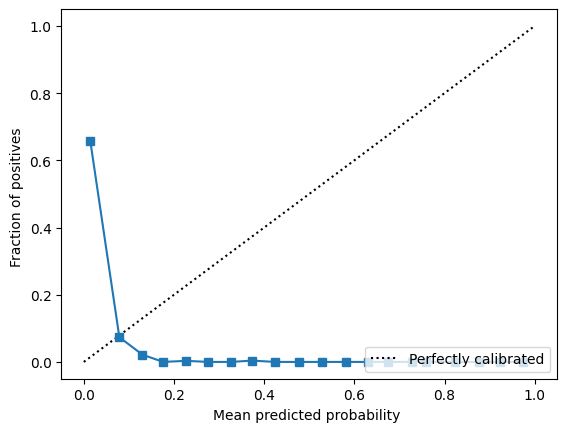

In [107]:
prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()
plt.show()

## Proba-Calibrated

In [108]:
from sklearn.calibration import CalibratedClassifierCV

In [122]:
cparams = { 
        'method': 'sigmoid',
#         'method': 'isotonic',
            'ensemble':True,
            'ensemble':False,
            'cv': 'prefit'}

In [123]:
calibrated = CalibratedClassifierCV(M, **cparams)

In [113]:
len(X_train)

972614

In [115]:
len(w_train)

972614

In [114]:
sum(groups['train'])

972614

In [124]:
calibrated.fit(X_train, y_train, 
          sample_weight=w_train,
          group=groups['train'])

2024/03/28 13:51:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f430763f19b64073b763ebb65abde6d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/28 13:51:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these column

CalibratedClassifierCV(cv='prefit', ensemble=False,
                       estimator=LGBMRankerBinaryClassifier(colsample_bytree=0.5013544317317782,
                                                            min_child_samples=51,
                                                            min_child_weight=1e-05,
                                                            num_leaves=21,
                                                            reg_alpha=0.1,
                                                            reg_lambda=5,
                                                            subsample=0.4301443471481221))

In [126]:
y_pred_c = calibrated.predict_proba(X_val)[:, 1]
y_c = calibrated.predict(X_val)

2024/03/28 13:52:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 13:52:54 WARNING mlflow.sklearn: Failed to log evaluation dataset inform

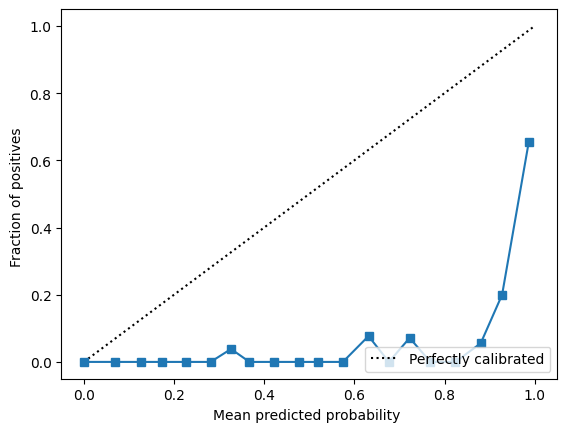

In [128]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_c, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_c)
disp.plot()

In [129]:
prec, recall, step = precision_recall_curve(y_val, y_pred_c, pos_label=1)

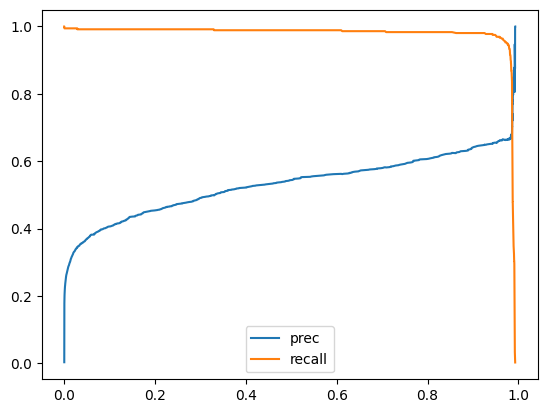

In [130]:
curve_df = pd.DataFrame({'prec':prec[:-1], 'recall':recall[:-1]}, index=step)
curve_df.plot();

In [137]:
run_name = 'lgbm_ranker_calibrated'

with mlflow.start_run(run_name=run_name):
    M.fit(X_train, y_train, 
          sample_weight=w_train,
          group=groups['train'])

    calibrated = CalibratedClassifierCV(M, **cparams)
    calibrated.fit(X_train, y_train, 
          sample_weight=w_train,
          group=groups['train'])
    mlflow.set_tags({'model':'lgbm_ranking_calibrated'})
#     mlflow.log_params(model.get_params())

    signature = infer_signature(X_train, y_train)
    
    mlflow.sklearn.log_model(
        calibrated,
        signature=signature,
        registered_model_name=metaflow_config["model_name"],
        artifact_path="model",
        metadata={'model': 'lgbm_ranking'},
        input_example=X_train.head(5),
    )

    val_metrics = {
        f"val_{scorer._score_func.__name__}": scorer(calibrated, X_old_val, y_old_val)
        for scorer in METRICS
    }
    mlflow.log_metrics(val_metrics)

2024/03/28 14:04:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 14:04:57 WARNING mlflow.lightgbm: Failed to log dataset information to M

[LightGBM] [Info] Calculating query weights...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1765
[LightGBM] [Info] Number of data points in the train set: 972614, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with p

2024/03/28 14:05:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/28 14:06:09 WARNING mlflow.models.model: Logging model metadata to the trac

In [138]:
print('!')

!
